In [117]:
import numpy as np
import matplotlib.pyplot as plt

In [119]:
H = np.loadtxt("Hmatrix2.txt",delimiter=',')
Axes0 = H.shape[0] #Rows
Axes1 = H.shape[1] #Cols
print(Axes0,Axes1)
# print(H)

3000 5000


In [135]:
class Node:
    def __init__(self, nodeID, connected_nodeList, bitValue,*args,**kwargs): 
        self.nodeID = nodeID #Helps to locate node in general list
        self.adjNodes = connected_nodeList # List of connected nodes to a particular node
        self.prevMsg = 2 #Set 2 as there is no initial messsage when started
        self.currMsg = bitValue
        self.FrmAdjNode = [None]*len(connected_nodeList) #Msg received from adj nodes


    def varToChk(self,chkNodes):
        if self.prevMsg==2:
            # print("First Iteration\n")
            for nodeInd in self.adjNodes: # From variable nodes adjacent node list 
                idInd = chkNodes[nodeInd].adjNodes.index(self.nodeID) #Index of checknodes in chkNodes list
                chkNodes[nodeInd].FrmAdjNode[idInd] = self.currMsg
                # print("ChkNodeID: ",chkNodes[nodeInd].nodeID, chkNodes[nodeInd].adjNodes," BitList: ",chkNodes[nodeInd].FrmAdjNode)
            self.prevMsg = self.currMsg
        else:
            # print("2+ Iteration\n")
            # self.prevMsg = self.currMsg
            for i in range(len(self.adjNodes)):
                flag=0
                # print(f"\nBitList: ",self.FrmAdjNode)
                for j in range(len(self.FrmAdjNode)): #Iterate through probab list sent by chk nodes
                    if  i == j:
                        continue
                    else:
                        if self.FrmAdjNode[j] !=-1:
                            msgToChk = self.FrmAdjNode[j] #Since VN's a repetation code
                            flag=1
                            break
                        # print(prob1)
                if flag==0 and self.currMsg==-1:
                    msgToChk = -1
                else:
                    msgToChk = self.currMsg
                chkNodeInd = self.adjNodes[i]
                varNodeInd = chkNodes[chkNodeInd].adjNodes.index(self.nodeID)
                chkNodes[chkNodeInd].FrmAdjNode[varNodeInd] = msgToChk
                # print("ChkNodeID: ",chkNodes[chkNodeInd].nodeID, chkNodes[chkNodeInd].adjNodes)

            
            # for bit in self.FrmAdjNode:
            if self.currMsg == -1:
                if 0 in self.FrmAdjNode:
                    self.currMsg = 0
                elif 1 in self.FrmAdjNode:
                    self.currMsg = 1
                

    def chkToVar(self,varNodes):
        for i in range(len(self.adjNodes)):
            parity = 0
            # print(self.FrmAdjNode)
            for j in range(len(self.FrmAdjNode)): #Iterate through probab list sent by var nodes
                rec_bit = self.FrmAdjNode[j]
                if i == j:
                    continue
                elif rec_bit == -1:
                    # print(rec_bit)
                    parity=-1   
                    break
                else:
                    parity = parity^rec_bit
                    
            varNodeInd = self.adjNodes[i]
            chknodeInd = varNodes[varNodeInd].adjNodes.index(self.nodeID)
            varNodes[varNodeInd].FrmAdjNode[chknodeInd] =  parity
            # print("VarNodeID: ",varNodes[varNodeInd].nodeID, varNodes[varNodeInd].adjNodes," BitList: ",varNodes[varNodeInd].FrmAdjNode,f" parity: {parity}")


In [140]:
def soft_decode_bec(varNodes,chkNodes):
    t = 0 #Iteration index
    errorList = [0]*25

    while(t<25):
        # print(f"\nIteration {t}")
        #variable node to check node logic
        for varNode in varNodes:
            # print(f"Var{varNode.nodeID} with bit:{varNode.currMsg} to chk\n")
            varNode.varToChk(chkNodes)
            # print(f"Var{varNode.nodeID} with bit:{varNode.currMsg}\n")

        #check node to variable node logic
        flag = [1]*len(chkNodes)
        for i in range(len(chkNodes)):
            chkNode = chkNodes[i]
            # print(f"chk{chkNode.nodeID} to Var\n")
            flag[i] = chkNode.chkToVar(varNodes)
        
                
        #Loop break condition and error counting
        currWord = []
        errCnt = 0
        for parity in varNodes:
            msg = parity.currMsg
            if msg == -1:
                errCnt+=1
            currWord.append(msg)
        # print(f"{t}_th Iter: ",currWord,errCnt)
        errorList[t] = (errCnt/len(currWord))

        # if 1 not in flag:
        #     return errorList,currWord
        if -1 not in currWord:
            # print(currWord)
            if sum(currWord)%2 == 0:
                return errorList,currWord

            
        t += 1
    return errorList,currWord

In [141]:
def generate_msg(p):
    # p = 0.3 #Probability of a bit to be an erasure
    Msg = np.random.randint(0, 1, size=Axes1)
    receivedMsg = Msg.copy()
    receivedMsg[np.random.rand(Axes1) < p] = -1
    # print(receivedMsg)
    return list(Msg),list(receivedMsg)

In [142]:
def initNodes(receivedMsg):
    varNodes = []
    chkNodes = []
    for i in range(Axes0): 
        temp1 = list(H[i].nonzero()[0]) #Finding adj nodes
        chkNodes.append(Node(nodeID=i, connected_nodeList=temp1, bitValue=2)) #Checknode initially has no message

    for i in range(Axes1): 
        temp2 = list(H[:,i].nonzero()[0])
        varNodes.append(Node(nodeID=i, connected_nodeList=temp2, bitValue=receivedMsg[i])) #Initializing variable nodes with received message
    
    return varNodes,chkNodes


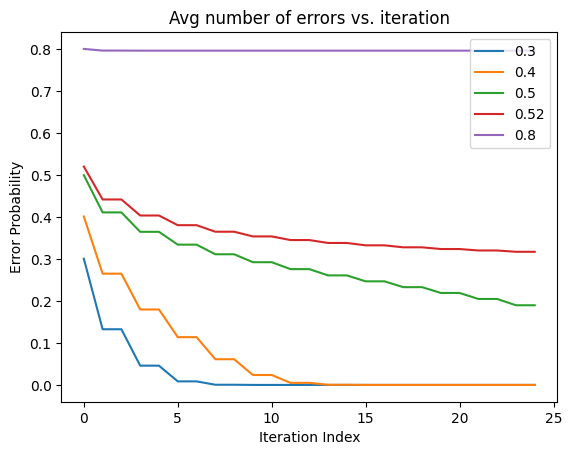

In [143]:
# L = [0, -1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0] #Error case
Nsim = 100
probab_erasure = [0.3, 0.4, 0.5, 0.52, 0.8]
for p in probab_erasure:
    avgError = np.zeros(25)
    err_allSim = [0]*Nsim
    for l in range(Nsim):
        originalMsg,errorMsg = generate_msg(p)
        varNodes,chkNodes = initNodes(receivedMsg=errorMsg)
        # print(errorMsg)
        errorList,decoded_wrd = soft_decode_bec(varNodes,chkNodes)
        err_allSim[l] = errorList

    npError = np.array(err_allSim)
    avgError = np.mean(npError,axis=0)
    # print(avgError)
    plt.plot(np.arange(0, 25), avgError,label=f'{p}')


# print(errorMsg,"\n",npError,"\n",avgError)
plt.title('Avg number of errors vs. iteration')
plt.xlabel('Iteration Index')
plt.ylabel('Error Probability')
plt.legend()
plt.show()
    